In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import qutip as q
import random as random
from mpl_toolkits.mplot3d import Axes3D

## Modelo de Dicke

In [3]:
# Funcion que, dado un vector y su dimension, me genera una base de vectores ortonormales en la cual este mismo vector es el primero
def generar_base_ortonormal(vector, dim):
    # Normalizar el primer vector
    v1 = vector / np.linalg.norm(vector)
    v1 = np.squeeze(np.asarray(v1, dtype = complex))
    # Generar una matriz aleatoria de dimensión (dim x dim)
    random_matrix = np.matrix(np.random.randn(dim, dim), dtype = complex)

    # Realizar el proceso de Gram-Schmidt para generar los vectores ortogonales restantes
    base = [v1]
    for i in range(1, dim):
        # Obtener el siguiente vector aleatorio
        #v = np.reshape(random_matrix[i], (1, max(random_matrix[i].shape)))
        v = np.squeeze(np.asarray(random_matrix[i], dtype = complex))
        #v = np.asarray(random_matrix[i], dtype = complex)
        #v = np.reshape(v, (1, max(v.shape)))
        # Restar las proyecciones de los vectores anteriores
        for j in range(i):
            v -= np.dot(v, base[j].T) * base[j]

        # Normalizar el vector resultante
        v /= np.linalg.norm(v)

        # Agregar el vector a la base ortonormal
        base.append(v)

    return base


# Funcion que me obtiene el hamiltoniano del modelo de atomos de rydberg
def rydberg(N, params):
    omega = params[0]
    delta = params[1]
    v = params[2]
    k = params[3]
    j = N/2
    
    Sx = q.jmat(j, 'x')
    Sz = q.jmat(j, 'z')
    Sm = q.jmat(j, '-')
    
    H = omega*Sx - delta*Sz + (v/N)*Sz*Sz
    J = np.sqrt(k/N)*Sm
    
    return H, J

def densidad(N):
    return q.basis(int(N+1), 0)*(q.basis(int(N+1), 0)).dag(), q.basis(int(N+1), 0)

# Funcion que me hace lo de Mpemba1 pero con qutip
def Mpemba1_mejorada_q(L, L_e, autovals, d, N, ini):

  # Se obtiene el segundo autovalor con la parte real mayor
  #segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(autovals)))

  # Hacemos reshape
  #L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_e[1], (d.shape[0], d.shape[1]))
  # Diagonalizamos la matriz L1
  todo = (q.Qobj(L1)).eigenstates(sparse = False, sort = 'low')
  vals = todo[0]
  vects = todo[1]
  #vects = [elemento.full() for elemento in todo[1]]
  """
  todo = (sp.Matrix(L1, dtype = complex)).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  vects = [np.reshape(elemento, (1, max(elemento.shape))) for elemento in vects]
  vals = list(np.array(vals, dtype = complex))
  """
  #print('Autovalores de L1: ')
  #print(vals)

  # Ahora, generamos la base auxiliar para el vector ini
  #base_aux = generar_base_ortonormal_q(ini)
  base_aux = generar_base_ortonormal(ini, N+1)
  base_aux= [q.Qobj(x) for x in base_aux]
  #base_aux = np.asarray([elemento for elemento in base_aux], dtype = complex)
  U_cambio = vects[0]*(base_aux[0].dag())
  #U_cambio = ketbra((vects[0]), base_aux[0])
  for i in range(1, N):
      U_cambio += vects[i]*(base_aux[i].dag())
    #U_cambio += ketbra((vects[i]), base_aux[i])

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  #tol = 1.0e-14
  es_cero = [(np.allclose(np.abs(vals[i]), 0.0, atol = 1e-5)) for i in range(len(vals))]

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    #print(vals[indice])
    #print(vals[indice])
    print(vals[indice])
    #U = ketbra(ini, vects[indice][0])
    U = ini*(vects[indice].dag())
    #U = ini*(vects[indice].dag())
    #U = ketbra(ini, vects[indice])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  #return q.Qobj(U), U_cambio
  return q.Qobj(U)*q.Qobj(U_cambio), U_cambio
    
# Funcion que nos calcula la transformacion de Mpemba2, pero con qutip
def Mpemba2_mejorada_q(L, L_e, vals, d, N, ini):
   # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  
  # segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(vals)))
  #segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo([np.real(elemento) for elemento in vals])
  #print('Autovalores', vals)
  #print('Segundo maximo', segundo_maximo)
  #indice_segundo_maximo = vals.index(segundo_maximo)
  #print('Indice segundo maximo: ' + str(indice_segundo_maximo))
  L_buenos= []
  for elemento in L_e:
      if(np.allclose(L*elemento, np.zeros_like(L*elemento), atol = 1e-2) == False):
          L_buenos.append(elemento)
  # La pasamos a matriz
  #L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_buenos[0], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_e[1], (d.shape[0], d.shape[1]))
  #L1 = sp.Matrix(L1, dtype = complex)
  #print('Autovalor asociado al l1: ', L1)

  # Diagonalizamos la matriz L1
  todo = (q.Qobj(L1)).eigenstates(sparse = False, sort = 'low')
  autovals = todo[0]
  autovects = todo[1]
  #autovects = [elemento.full() for elemento in todo[1]]
  """
  todo = L1.eigenvects()
  autovals = [tup[0] for tup in todo]
  autovects = [np.array(tup[2][0], dtype = complex) for tup in todo]
  autovals = list(np.array(autovals, dtype = complex))
  """
  #print('Autovalores de L1: ')
  #print(autovals)

  # Ahora, generamos la base auxiliar para el vector estado inicial
  #base_aux = generar_base_ortonormal_q(ini)
  base_aux = generar_base_ortonormal(ini, N+1)
  base_aux = [q.Qobj(x) for x in base_aux]
  #print('Dimension: ', base_aux[2].shape)
  #base_aux = np.array([elemento for elemento in base_aux], dtype = complex)
  
  # Con esto, podemos generar la primera transformacion
  U_cambio = autovects[0]*base_aux[0].dag()
  #U_cambio = ketbra(autovects[0], base_aux[0])
  for i in range(1, N):
      U_cambio += autovects[i]*(base_aux[i].dag())
      
  #es_cero = [(np.isclose(np.abs(autovals[i]), 0, atol = 1e-4)) for i in range(len(autovals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  #indice_contrario = 0
  #indice_inicial = es_cero.index(False)
  #print(indice_inicial)
  #autovals = eliminar_duplicados(autovals)
  #es_contrario = [np.real(autovals[indice_inicial])*np.real(autovals[i]) < 0 for i in range(len(autovals))]
  if(np.real(autovals[0])*np.real(autovals[-1]) < 0):
    #indice_contrario = es_contrario.index(True)
    #print('(indice contrario, indice inicial, len(autovects)) = ' + str(indice_contrario) + ', ' + str(indice_inicial) + ', '  + ' ' + str(autovects[0].shape))
    F = autovects[0]*autovects[-1].dag() + autovects[-1]*autovects[0].dag()
    #F = autovects[indice_inicial]*autovects[indice_contrario].dag() + autovects[indice_contrario]*autovects[indice_inicial].dag()
    #F = ketbra(autovects[indice_inicial], autovects[indice_contrario]) + ketbra(autovects[indice_contrario], autovects[indice_inicial])
    s = np.arctan(np.sqrt((np.abs(autovals[0]))/(np.abs(autovals[-1]))))
    #s = np.arctan(np.sqrt((np.abs(autovals[indice_inicial]))/(np.abs(autovals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    #print((autovals[indice_inicial], autovals[indice_contrario]))
    #print(F)
    #identidad = kronecker(iden, 0, N)
    identidad = q.qeye(F.shape[0])
    U = identidad + (np.cos(s) - 1.0)*(F*F) - 1.j*np.sin(s)*F
    #U = identidad + (np.cos(s) - 1.0)*(np.dot(np.conjugate(F.T), F)) - 1.j*np.sin(s)*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  return q.Qobj(U)*q.Qobj(U_cambio), U_cambio, (autovals[0], autovals[-1])
  #return q.Qobj(U), U_cambio, (autovals[0], autovals[-1])
    
# Funcion que me genera una base ortonormal en la cual esta incluido un vector que yo le paso
def generar_base_ortonormal_q(vector):
    # Convertir el vector a un objeto Qobj
    vector_qobj = q.Qobj(vector)

    # Normalizar el vector
    vector_normalizado = vector_qobj.unit()

    # Definir el primer vector de la base como el vector normalizado
    base = [vector_normalizado]

    # Generar los vectores restantes de la base utilizando Gram-Schmidt
    for i in range(len(vector.full())):
        if i == 0:
            continue
        # Proyectar el vector original sobre los vectores de la base ya generados
        proyecciones = [vector_normalizado.overlap(v) * v for v in base]
        # Restar las proyecciones del vector original para ortogonalizarlo
        vector_ortogonalizado = vector_qobj - sum(proyecciones)
        # Normalizar el vector ortogonalizado para obtener un nuevo vector de la base
        #vector_normalizado = vector_ortogonalizado.unit()
        vector_normalizado = vector_ortogonalizado
        # Agregar el nuevo vector a la base
        base.append(vector_normalizado)
    
    #base = [elemento.unit() for elemento in base]
    return base

def densidad_bueno(N):
    M = 2 # Numero de fotones
    #M = 8
    j = N/2.0
    n = 2*j + 1
    #Jz = q.tensor(q.qeye(M), spin_operator(N, 'z')[0])
    #print(np.allclose(spin_operator(N, 'z')[0], q.jmat(2*j, 'z')))
    #Jz = q.tensor(q.qeye(M), q.jmat(j, 'z'))
    Jz = q.jmat(j, 'z')
    print(Jz.shape)
    # Creamos la base de autoestados de sz
    todo = Jz.eigenstates(sparse = True, sort = 'high')
    base = todo[1]
    #base = [elemento.full() for elemento in todo[1]]
    #base = [np.array(tup[2], dtype = complex) for tup in todo]
    #base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]
    #print(base)

    # Construimos el vector inicial
    a, b = random.random(), random.random()
    ini = (a + b*1.j)*base[0]
    for i in range(1, len(base)):
      a, b = random.random(), random.random()
      ini += (a + b*1.j)*base[i]
    # Le hacemos el ketbra para construir la matriz densidad

    ini = ini.unit()
    d = ini*ini.dag()
    #d = ketbra(ini, ini)
    #res = d/(np.linalg.norm(d))
    return d, ini

def dicke_bueno(N, params):
    M = 2
    #M = 8
    j = N/2.0
    n = 2*j + 1
    Jz = q.jmat(j, 'z')
    Jx = q.jmat(j, 'x')
    #Jz = q.tensor(q.qeye(M), q.jmat(j, 'z'))
    #Jx = q.tensor(q.qeye(M), q.jmat(j, 'x'))
    #Jz = q.tensor(q.qeye(M), spin_operator(N, 'z')[0])
    #Jx = q.tensor(q.qeye(M), spin_operator(N, 'x')[0])
    
    sigma = params[0]
    w = params[1]
    k = params[2]
    g = params[3]
    
    
    H = sigma*Jz - ((4.0*w*g*g)/(4.0*w**2 + k**2))*(1.0/N)*Jx*Jx
    J = ((2.0*np.abs(g)*np.sqrt(k))/(np.sqrt(N*(4*w*w + k*k))))*Jx
    #J = -((np.sqrt(k)*g*(4*w + 2*1.j*k))/(np.sqrt(N)*(4*w*w + k*k)))*Jx
    return H, J

def spin_operator(N, component):
    """
    N: int (numero de qubits)
    Component: str (componente del momento angular, 'x', 'y', 'z')
    returns Qobj
    """
    if component == 'x':
        op = q.sigmax()
    elif component == 'y':
        op = q.sigmay()
    elif component == 'z':
        op = q.sigmaz()
    else: 
        raise ValueError('La componente tiene que se x, y, o z')
    
    # Construimos los operadores
    total_operator = 0
    indv_operators = []
    for i in range(N):
        operators = [q.qeye(2) for _ in range(N)]
        operators[i] = op
        indv_operators.append(q.tensor(operators))
        total_operator += q.tensor(operators)
    
    return total_operator, indv_operators

def ising(params, N):
    # Parametros
    om = params[0]
    v = params[1]
    a = params[2]
    gam = params[3]
    
    # Sacamos los terminos
    spin_z = spin_operator(N, component = 'z')[1]
    todo_x = spin_operator(N, component = 'x')[0]
    spin_x = spin_operator(N, component = 'x')[1]
    spin_y = spin_operator(N, component = 'y')[1]
    
    list_J = []
    suma = 0
    for i in range(len(spin_z)):
        list_J.append((np.sqrt(gam)/2)*(spin_x[i] - 1.j*spin_y[i]))
        for j in range(len(spin_z)):
            if(i < j):
                suma += (spin_z[i]*spin_z[j])/(np.abs(i-j)**a)
                
    H = om*todo_x + v*suma
    return H, list_J

# Funcion que me da el hamiltoniano y el operador de salto del modelo de Ising pero para a tendiendo a infinito
def ising_inf(params, N):
    # Parametros
    om = params[0]
    v = params[1]
    a = params[2]
    gam = params[3]
    
    # Sacamos los terminos
    spin_z = dicke.spin_operator(N, component = 'z')[1]
    todo_x = dicke.spin_operator(N, component = 'x')[0]
    spin_x = dicke.spin_operator(N, component = 'x')[1]
    spin_y = dicke.spin_operator(N, component = 'y')[1]
    
    list_J = []
    suma = 0
    for i in range(len(spin_z)):
        list_J.append((np.sqrt(gam)/2)*(spin_x[i] - 1.j*spin_y[i]))
        for j in range(len(spin_z)):
            if(i < j):
                suma += spin_z[i]*spin_z[j]/np.abs(i-j)**a
                
    H = om*todo_x
    return H, list_J

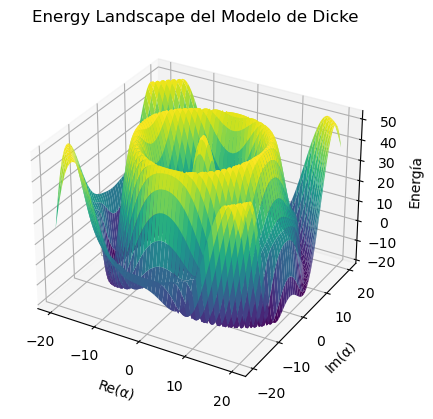

In [4]:
# Definición de parámetros
N = 2  # Número de fotones
M = 40 # Numero de atomos
j = M/2.0
omega = 1.0  # Frecuencia del modo del campo
omega0 = 1.0  # Frecuencia de transición atómica
lambda_c = 1.0  # Fuerza de acoplamiento

"""
# Definición de operadores
a = tensor(destroy(N), qeye(M+1))
adag = tensor(create(N), qeye(M+1))
#Jz = tensor(qeye(N), sigmaz()/2)
Jz = tensor(qeye(N), jmat(j, 'z'))
#Jp = tensor(qeye(N), sigmap())
Jp = tensor(qeye(N), jmat(j, '+'))
Jm = tensor(qeye(N), jmat(j, '-'))
#Jm = tensor(qeye(N), sigmam())
"""
params = [1, 1, 1, 1]
# Hamiltoniano del modelo de Dicke
#H = omega * adag * a + omega0 * Jz + (lambda_c / np.sqrt(N)) * (adag + a) * (Jp + Jm)
#H = omega*adag*a
#H, J = dicke_bueno(M, [1, 1, 1, 1])
H, J = rydberg(M, [1, -1, 3, 1])
#H = omega0*Jz # Hamiltoniano con un solo qubit
# Rango de valores para las posiciones del campo
x_values = np.linspace(-20, 20, 100)
y_values = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x_values, y_values)
Z = np.zeros_like(X)

# Cálculo del paisaje energético
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        alpha = X[i, j] + 1j * Y[i, j]
        #coherent_state = tensor(coherent(N, alpha), basis(2, 0))
        #coherent_state = q.tensor(q.coherent(N, alpha), q.basis(M+1, 0))
        coherent_state = q.coherent(M+1, alpha)
        Z[i, j] = (coherent_state.dag() * H * coherent_state).full().real

# Visualización del paisaje energético
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
ax.set_zlabel('Energía')
plt.title('Energy Landscape del Modelo de Dicke')
plt.show()

In [5]:
H.shape

(41, 41)

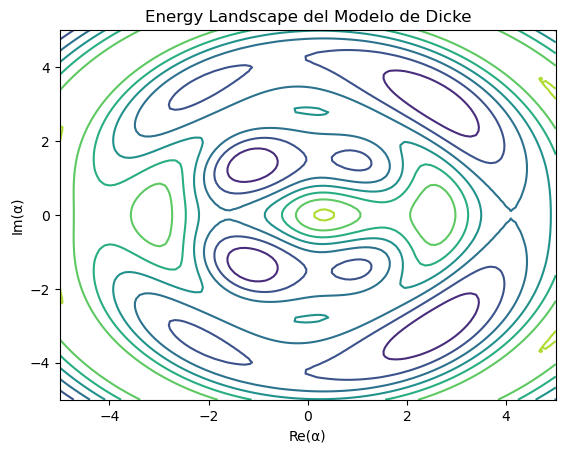

In [6]:
# Definición de parámetros
M = 3 # Numero de atomos
om = 1.0
v = 1.0
a = 0.0
gam = 1.0

params = [om, v, a, gam]
# Hamiltoniano del modelo de Dicke
#H = omega * adag * a + omega0 * Jz + (lambda_c / np.sqrt(N)) * (adag + a) * (Jp + Jm)
#H = omega*adag*a
#H, J = dicke_bueno(M, [1, 1, 1, 1])
H, J = ising(params, M)
#H = omega0*Jz # Hamiltoniano con un solo qubit
# Rango de valores para las posiciones del campo
x_values = np.linspace(-5, 5, 100)
y_values = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_values, y_values)
Z = np.zeros_like(X)

# Cálculo del paisaje energético
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        alpha = X[i, j] + 1j * Y[i, j]
        #coherent_state = tensor(coherent(N, alpha), basis(2, 0))
        #coherent_state = q.tensor(q.coherent(N, alpha), q.basis(M+1, 0))
        coherent_state = q.coherent(int(2**M), alpha)
        Z[i, j] = (coherent_state.dag() * q.Qobj(H.full()) * coherent_state).full().real

# Visualización del paisaje energético
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
#ax.plot_surface(X, Y, Z, cmap='inferno')
ax.contour(X, Y, Z)
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
#ax.set_zlabel('Energía')
plt.title('Energy Landscape del Modelo de Dicke')
plt.show()

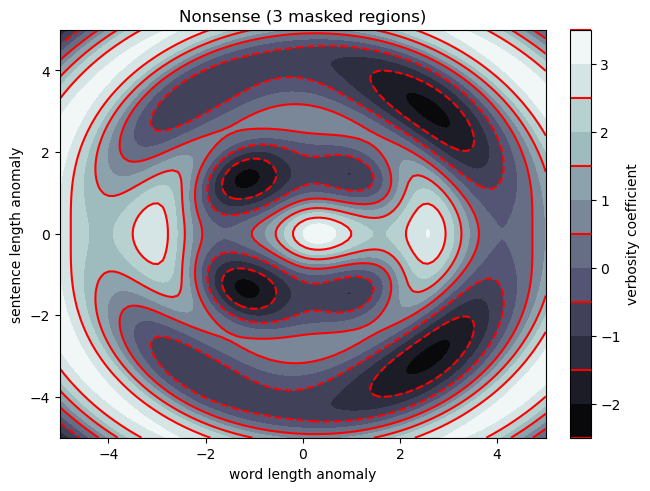

In [7]:
fig1, ax2 = plt.subplots(layout='constrained')
CS = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.bone)

# Note that in the following, we explicitly pass in a subset of the contour
# levels used for the filled contours.  Alternatively, we could pass in
# additional levels to provide extra resolution, or leave out the *levels*
# keyword argument to use all of the original levels.

CS2 = ax2.contour(CS, levels=CS.levels[::2], colors='r')

ax2.set_title('Nonsense (3 masked regions)')
ax2.set_xlabel('word length anomaly')
ax2.set_ylabel('sentence length anomaly')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('verbosity coefficient')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)

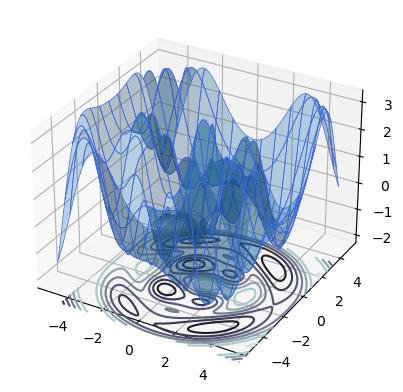

In [8]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, Z, zdir='z', offset=-3, cmap='bone')
#ax.contour(X, Y, Z, zdir='x', offset=-4, cmap='coolwarm')
#ax.contour(X, Y, Z, zdir='y', offset=4, cmap='coolwarm')

#ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
#       xlabel='X', ylabel='Y', zlabel='Z')

plt.show()

In [37]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight